# Tree Models

This notebooks contains my exploration of tree-based models including decision trees, random forest models, gradient boosting machines, and Bayesian Additive Regression Trees.  The product of this notebook will be a model that can be used for prediction.

------

## Contents<a id='Contents'></a>
* [XXXX](#introduction--feature-descriptions)
* [Imports & Reading Data](#imports--readingpreparing-data)
---

## Imports & Reading Data

In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns',None)
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import recall_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier

from csv import DictWriter

In [2]:
# Read csv into a pandas dataframe
df = pd.read_csv('../data/cleaned_heart_data.csv')
df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ExerciseAngina_Y,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ST_Slope_Flat,ST_Slope_Up,Oldpeak_is_zero
0,40,140,289.0,0,172,0.0,0,1,0,1,0,0,1,0,0,1,1
1,49,160,180.0,0,156,1.0,1,0,0,0,1,0,1,0,1,0,0
2,37,130,283.0,0,98,0.0,0,1,0,1,0,0,0,1,0,1,1
3,48,138,214.0,0,108,1.5,1,0,1,0,0,0,1,0,1,0,0
4,54,150,195.0,0,122,0.0,0,1,0,0,1,0,1,0,0,1,1


In [3]:
# Split data into predictor features (X) and target feature (y)
X = df.drop('HeartDisease', axis = 1)
y = df['HeartDisease']

In [4]:
# Split the data into a training and a test set (random state set for reproducability)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [5]:
#Impute missing cholesterol with medians for baseline models
imputer_for_baseline = SimpleImputer(strategy='median')
X_train_imputed =imputer_for_baseline.fit_transform(X_train)
X_test_imputed = imputer_for_baseline.fit_transform(X_test)

## Single Decision Tree Regressor

In [6]:
single_tree_pipe = make_pipeline(SimpleImputer(),
                                 DecisionTreeClassifier(random_state=0))
params = {'simpleimputer__strategy': ['mean', 'median'],
          'decisiontreeclassifier__max_depth': range(2, 25, 2),
          'decisiontreeclassifier__class_weight': [None, 'balanced'],
          'decisiontreeclassifier__criterion': ['gini', 'entropy', 'log_loss']}

grid_cv = GridSearchCV(estimator=single_tree_pipe, param_grid=params, cv=5, scoring='recall', n_jobs=-1)
grid_cv.fit(X_train, y_train)

grid_cv_results=pd.DataFrame(grid_cv.cv_results_).sort_values('mean_test_score', ascending=False)
grid_cv_results[['param_simpleimputer__strategy',
                 'param_decisiontreeclassifier__max_depth', 'param_decisiontreeclassifier__class_weight', 'param_decisiontreeclassifier__criterion', 
                 'mean_test_score', 'std_test_score', 'rank_test_score']].head(10)

,param_simpleimputer__strategy,param_decisiontreeclassifier__max_depth,param_decisiontreeclassifier__class_weight,param_decisiontreeclassifier__criterion,mean_test_score,std_test_score,rank_test_score
0,mean,2,None,gini,0.852454,0.073594,1
24,mean,2,None,entropy,0.852454,0.073594,1
48,mean,2,None,log_loss,0.852454,0.073594,1
49,median,2,None,log_loss,0.852454,0.073594,1
25,median,2,None,entropy,0.852454,0.073594,1
1,median,2,None,gini,0.852454,0.073594,1
2,mean,4,None,gini,0.840259,0.038444,7
52,mean,6,None,log_loss,0.840229,0.027743,8
28,mean,6,None,entropy,0.840229,0.027743,8
27,median,4,None,entropy,0.840112,0.021463,10


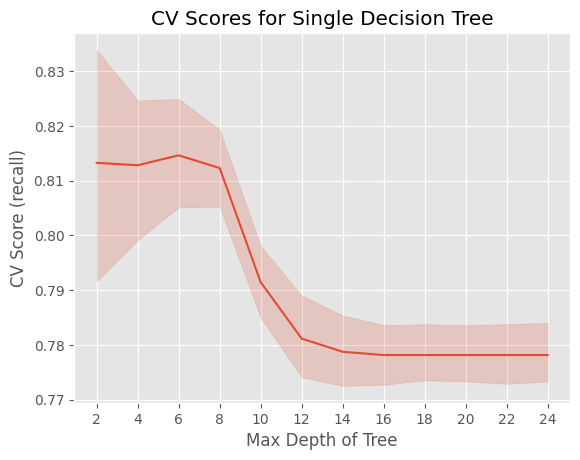

In [7]:
tree_max_depth_plot = sns.lineplot(data = grid_cv_results, 
                                   x = 'param_decisiontreeclassifier__max_depth', 
                                   y = 'mean_test_score')
tree_max_depth_plot.set_xticks(params['decisiontreeclassifier__max_depth'])
plt.title('CV Scores for Single Decision Tree')
plt.ylabel('CV Score (recall)')
plt.xlabel('Max Depth of Tree')
plt.show()

In [8]:
final_tree = grid_cv.best_estimator_
final_tree.fit(X_train, y_train)

y_test_pred = final_tree.predict(X_test)
single_tree_test_recall = recall_score(y_test, y_test_pred)
single_tree_cv_score = cross_val_score(final_tree, X_train, y_train, cv = 5, scoring = "recall").mean()

print(f'Single Tree Train CV Score (recall): {single_tree_cv_score:.3f}')
print(f'Single Tree Test Recall: {single_tree_test_recall:.3f}')

Single Tree Train CV Score (recall): 0.852
Single Tree Test Recall: 0.947


In [9]:
final_tree_performance = {'model': 'decision_tree', 
                          'params': final_tree.get_params(), 
                          'train_score_cv_recall': single_tree_cv_score, 
                          'test_score_recall': single_tree_test_recall}

field_names = final_tree_performance.keys()

with open('../data/models.csv', 'a') as file:
    writer = DictWriter(file, fieldnames=field_names)
    writer.writerow(final_tree_performance)

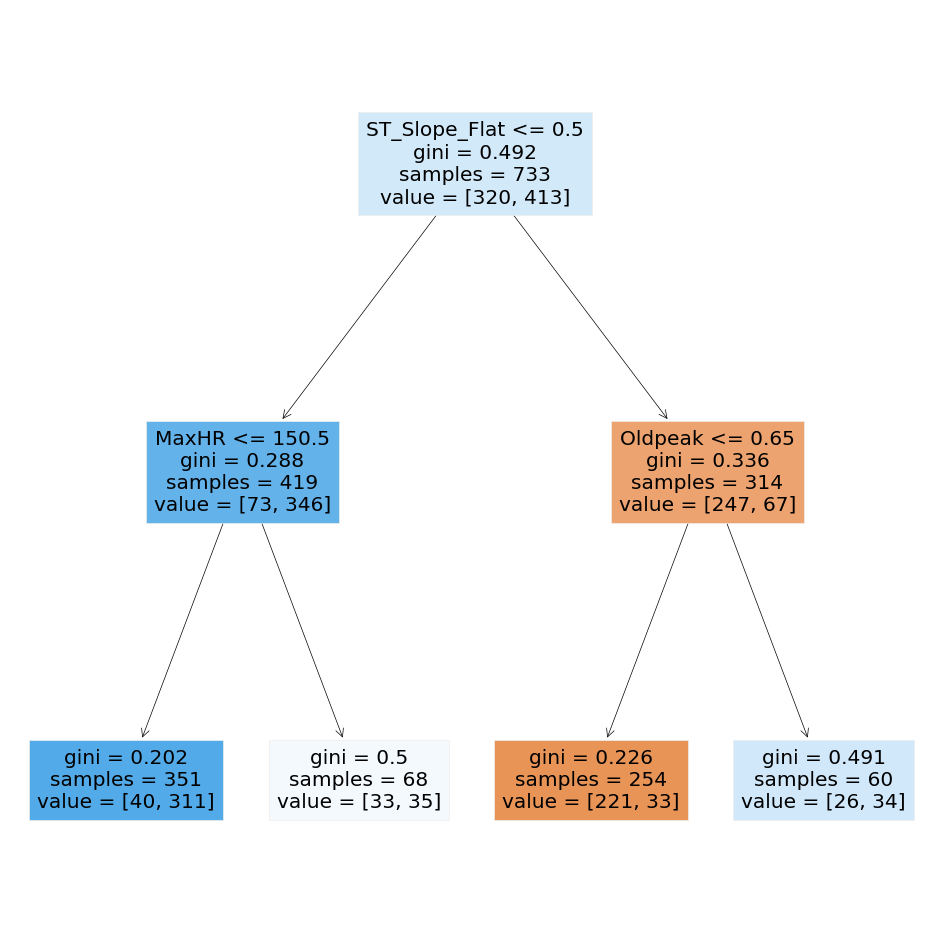

In [13]:
plt.figure(figsize=(12,12))
features = df.columns
plot_tree(final_tree['decisiontreeclassifier'], feature_names=features, filled=True, max_depth=2)
plt.show()

### Cost Complexity Pruning

In [25]:
#Impute with mean first
mean_imputer = SimpleImputer(strategy='mean')
X_train_mean_imputed = mean_imputer.fit_transform(X_train)
X_test_mean_imputed = mean_imputer.fit_transform(X_test)

path = final_tree['decisiontreeclassifier'].cost_complexity_pruning_path(X_train_mean_imputed, 
                                                                         y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [26]:
trees = []

for alpha in ccp_alphas:
    subtree = DecisionTreeClassifier(random_state=0, ccp_alpha=alpha)
    subtree.fit(X_train_mean_imputed, y_train)
    trees.append(subtree)

In [27]:
trees = trees[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [subtree.tree_.node_count for subtree in trees]
depth = [subtree.tree_.max_depth for subtree in trees]

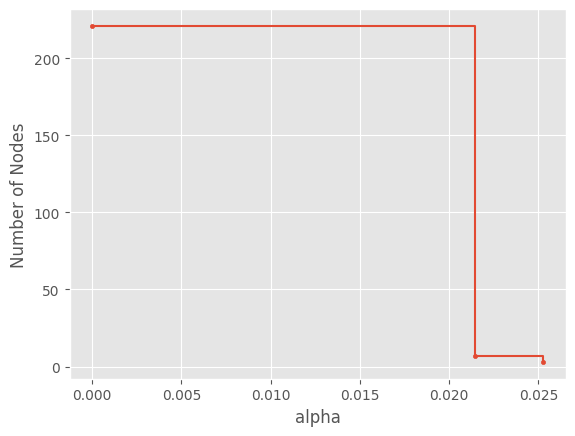

In [28]:
plt.scatter(ccp_alphas, node_counts, marker='.')
plt.plot(ccp_alphas, node_counts, drawstyle="steps-post")
plt.ylabel('Number of Nodes')
plt.xlabel('alpha')
plt.show()

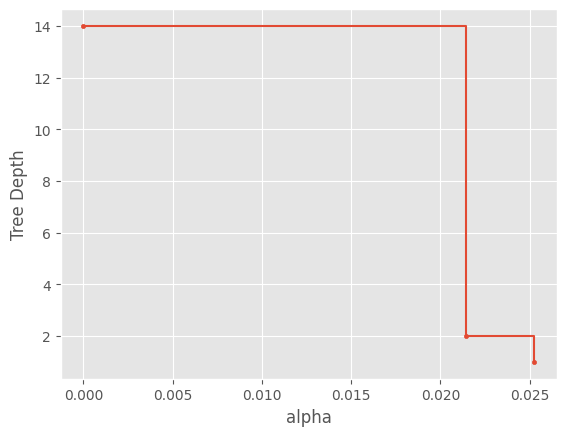

In [29]:
plt.scatter(ccp_alphas, depth, marker='.')
plt.plot(ccp_alphas, depth, drawstyle="steps-post")
plt.ylabel('Tree Depth')
plt.xlabel('alpha')
plt.show()

In [30]:
cv_recall = []
test_recall = []

for subtree in trees:
    cv_recall.append(cross_val_score(subtree, X_train_mean_imputed, y_train,
                                     scoring='recall', cv = 5).mean())
    y_test_pred = subtree.predict(X_test_mean_imputed)
    test_recall.append(recall_score(y_test, y_test_pred))

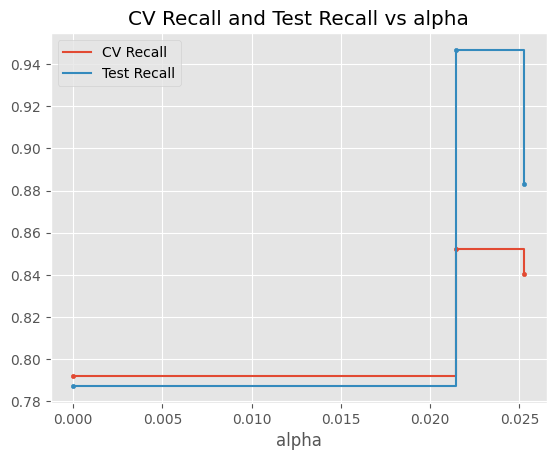

In [31]:
plt.scatter(ccp_alphas, cv_recall, marker='.')
plt.scatter(ccp_alphas, test_recall, marker='.')
plt.plot(ccp_alphas, cv_recall, label='CV Recall', drawstyle="steps-post")
plt.plot(ccp_alphas, test_recall, label='Test Recall', drawstyle="steps-post")
plt.xlabel('alpha')
plt.legend()
plt.title('CV Recall and Test Recall vs alpha')
plt.show()

## Random Forest Model

In [33]:
forest_baseline = RandomForestClassifier(random_state=0, oob_score=True)
cv_score_forest_baseline = cross_val_score(forest_baseline, X_train_imputed, y_train, cv=5, scoring='recall').mean()
forest_baseline.fit(X_train_imputed, y_train)
baseline_forest_y_hat = forest_baseline.predict(X_test_imputed)
recall_forest_baseline = recall_score(y_test, baseline_forest_y_hat)
oob_score_forest_baseline = forest_baseline.oob_score_

print(f'Baseline Random Forest Train CV Score (recall): {cv_score_forest_baseline:.3f}')
print(f'Baseline Random Forest Test Recall: {recall_forest_baseline:.3f}')
print(f'Baseline Random Forest OOB Score (Accuracy) {oob_score_forest_baseline:.4f}')

Baseline Random Forest Train CV Score (recall): 0.886
Baseline Random Forest Test Recall: 0.915
Baseline Random Forest OOB Score (Accuracy) 0.8472


In [37]:
forest_pipe = make_pipeline(SimpleImputer(),
                            RandomForestClassifier(random_state=0, oob_score=True))
params = {'simpleimputer__strategy': ['mean', 'median'],
          'randomforestclassifier__n_estimators': [10, 25, 50, 100, 250, 500],
          'randomforestclassifier__max_depth': range(6, 16, 2),
          'randomforestclassifier__min_samples_split': [2, 5],
          'randomforestclassifier__max_features': ['sqrt', 0.5],
          'randomforestclassifier__criterion': ['gini', 'entropy', 'log_loss'],
          'randomforestclassifier__class_weight': [None, 'balanced', 'balanced_subsample']
          }

grid_cv_tree = GridSearchCV(estimator=forest_pipe, param_grid=params, 
                            cv=5, scoring='recall', n_jobs=-1)
grid_cv_tree.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(oob_score=True,
                                                               random_state=0))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__class_weight': [None,
                                                                  'balanced',
                                                                  'balanced_subsample'],
                         'randomforestclassifier__criterion': ['gini',
                                                               'entropy',
                                                               'log_loss'],
                         'randomforestclassifier__max_depth': range(6, 16, 2),
                         'randomforestclassifier__max_features': ['sqrt', 0.5],
                         'randomforestclassifier__min_samples_split': [2, 5],
                         'randomforestclassifier__n_estimators': [10, 25, 50,
                                                                  100, 250,
                                                                  500],
                         'simpleimputer__strategy': ['mean', 'median']},
             scoring='recall')

In [39]:
grid_cv_results_tree=pd.DataFrame(grid_cv_tree.cv_results_).sort_values('mean_test_score', ascending=False)
grid_cv_results_tree[['param_simpleimputer__strategy',
                     'param_randomforestclassifier__criterion', 
                     'param_randomforestclassifier__class_weight',
                     'param_randomforestclassifier__max_depth', 
                     'param_randomforestclassifier__max_features', 'param_randomforestclassifier__min_samples_split', 'param_randomforestclassifier__n_estimators', 
                     'mean_test_score', 'std_test_score', 'rank_test_score']].head(10)

,param_simpleimputer__strategy,param_randomforestclassifier__criterion,param_randomforestclassifier__class_weight,param_randomforestclassifier__max_depth,param_randomforestclassifier__max_features,param_randomforestclassifier__min_samples_split,param_randomforestclassifier__n_estimators,mean_test_score,std_test_score,rank_test_score
919,median,gini,balanced,14,sqrt,2,100,0.903262,0.046808,1
398,mean,entropy,None,12,sqrt,5,25,0.900852,0.051218,2
638,mean,log_loss,None,12,sqrt,5,25,0.900852,0.051218,2
448,mean,entropy,None,14,sqrt,5,50,0.900823,0.038959,4
688,mean,log_loss,None,14,sqrt,5,50,0.900823,0.038959,4
871,median,gini,balanced,12,sqrt,2,100,0.898472,0.051832,6
823,median,gini,balanced,10,sqrt,2,100,0.898443,0.052393,7
400,mean,entropy,None,12,sqrt,5,50,0.898443,0.053490,7
640,mean,log_loss,None,12,sqrt,5,50,0.898443,0.053490,7
686,mean,log_loss,None,14,sqrt,5,25,0.898413,0.046008,10


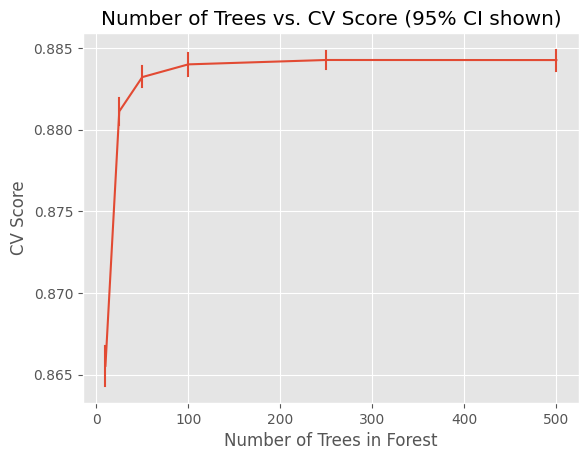

In [40]:
sns.lineplot(data=grid_cv_results_tree, x='param_randomforestclassifier__n_estimators',
             y='mean_test_score', err_style='bars')
plt.ylabel('CV Score')
plt.xlabel('Number of Trees in Forest')
plt.title('Number of Trees vs. CV Score (95% CI shown)')
plt.show()

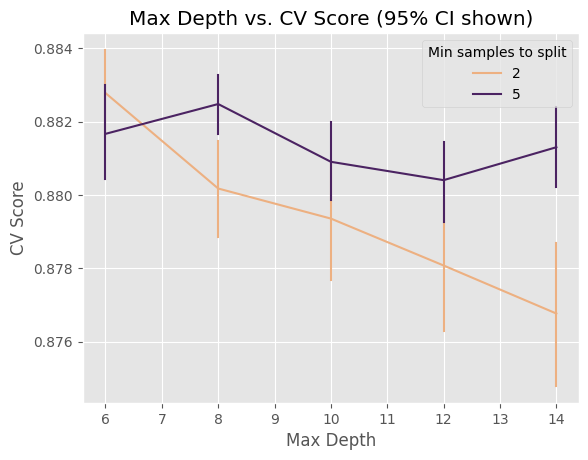

In [41]:
sns.lineplot(data=grid_cv_results_tree, x='param_randomforestclassifier__max_depth', 
             y='mean_test_score', hue='param_randomforestclassifier__min_samples_split', err_style='bars', palette='flare')
plt.ylabel('CV Score')
plt.xlabel('Max Depth')
plt.title('Max Depth vs. CV Score (95% CI shown)')
plt.legend(title='Min samples to split')
plt.show()

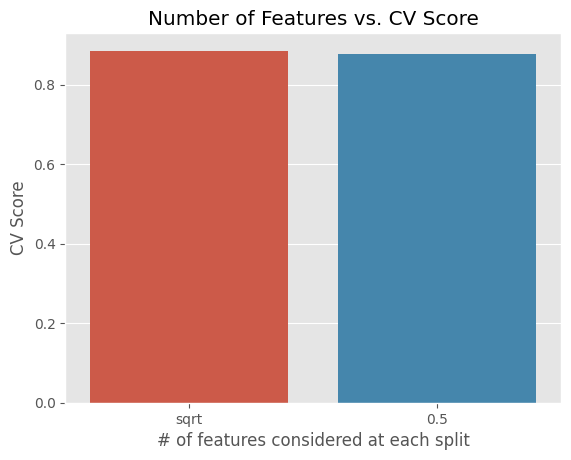

In [44]:
sns.barplot(data=grid_cv_results_tree, x='param_randomforestclassifier__max_features', 
             y='mean_test_score')
plt.ylabel('CV Score')
plt.xlabel('# of features considered at each split')
plt.title('Number of Features vs. CV Score')
plt.show()

In [45]:
grid_cv_tree.best_params_

{'randomforestclassifier__class_weight': 'balanced',
 'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': 14,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 100,
 'simpleimputer__strategy': 'median'}

In [47]:
final_random_forest = grid_cv_tree.best_estimator_
final_random_forest.fit(X_train, y_train)
y_hat_forest = final_random_forest.predict(X_test)
recall_forest = recall_score(y_test, y_hat_forest)
final_forest_oob_score = final_random_forest['randomforestclassifier'].oob_score_

print(f'Random Forest Train CV Score (recall): {grid_cv_tree.best_score_:.3f}')
print(f'Random Forest Test Recall: {recall_forest:.3f}')
print(f'Random Forest OOB Score (Accuracy) {final_forest_oob_score:.4f}')

Random Forest Train CV Score (recall): 0.903
Random Forest Test Recall: 0.947
Random Forest OOB Score (Accuracy) 0.8458


In [48]:
final_rf_performance = {'model': 'random_forest', 
                          'params': final_random_forest.get_params(), 
                          'train_score_cv_recall': grid_cv_tree.best_score_, 
                          'test_score_recall': recall_forest}

field_names = final_rf_performance.keys()

with open('../data/models.csv', 'a') as file:
    writer = DictWriter(file, fieldnames=field_names)
    writer.writerow(final_rf_performance)

## Gradient Boosted Trees

### Baseline GBM

In [53]:
gbm_baseline = GradientBoostingClassifier(random_state=0)
cv_score_gbm_baseline = cross_val_score(gbm_baseline, X_train_imputed, y_train, cv=5, 
                                        scoring='recall').mean()
gbm_baseline.fit(X_train_imputed, y_train)
gbm_baseline_recall = recall_score(y_test, gbm_baseline.predict(X_test_imputed))

print(f'GBM Baseline CV Score: {cv_score_gbm_baseline}')
print(f'GBM Baseline Test Recall: {gbm_baseline_recall}')

GBM Baseline CV Score: 0.878959741404643
GBM Baseline Test Recall: 0.925531914893617


In [54]:
gbm_baseline.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 0,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [58]:
print('Baseline Feature Importances:\n')
for i,j in zip(X.columns, gbm_baseline.feature_importances_):
    print(i, ': ', j)

Baseline Feature Importances:

Age :  0.03762026102500904
RestingBP :  0.03938118212701482
Cholesterol :  0.04868415625879061
FastingBS :  0.03380601188074685
MaxHR :  0.10136909633622353
Oldpeak :  0.09255158323774834
Sex_M :  0.05658695989975604
ExerciseAngina_Y :  0.05230455357570814
ChestPainType_ATA :  0.032081451700303576
ChestPainType_NAP :  0.03388344897826383
ChestPainType_TA :  0.011448236346952521
RestingECG_Normal :  0.0013786665861260422
RestingECG_ST :  0.005582144861358102
ST_Slope_Flat :  0.017713684159826965
ST_Slope_Up :  0.43436508585862194
Oldpeak_is_zero :  0.001243477167549642


### HyperParameter Tuning

In [60]:
gbm_pipe = make_pipeline(SimpleImputer(),
                         GradientBoostingClassifier(random_state=0))

gbm_params = {'simpleimputer__strategy': ['mean', 'median'],
              'gradientboostingclassifier__n_estimators': [25, 50, 100, 250, 500, 1000],
              'gradientboostingclassifier__loss': ['log_loss', 'exponential'],
              'gradientboostingclassifier__learning_rate': [0.01, 0.05, 0.1],
              'gradientboostingclassifier__subsample': [0.8, 0.9, 1.0],
              'gradientboostingclassifier__min_samples_split': [2,5,10],
              'gradientboostingclassifier__max_depth': [2, 4, 8],
              'gradientboostingclassifier__max_features': ['sqrt', 0.5]
              }

grid_cv_gbm = GridSearchCV(gbm_pipe, param_grid=gbm_params, cv=5, scoring='recall', n_jobs=-1)
grid_cv_gbm.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier(random_state=0))]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__learning_rate': [0.01,
                                                                       0.05,
                                                                       0.1],
                         'gradientboostingclassifier__loss': ['log_loss',
                                                              'exponential'],
                         'gradientboostingclassifier__max_depth': [2, 4, 8],
                         'gradientboostingclassifier__max_features': ['sqrt',
                                                                      0.5],
                         'gradientboostingclassifier__min_samples_split': [2, 5,
                                                                           10],
                         'gradientboostingclassifier__n_estimators': [25, 50,
                                                                      100, 250,
                                                                      500,
                                                                      1000],
                         'gradientboostingclassifier__subsample': [0.8, 0.9,
                                                                   1.0],
                         'simpleimputer__strategy': ['mean', 'median']},
             scoring='recall')

In [61]:
grid_cv_results_gbm=pd.DataFrame(grid_cv_gbm.cv_results_).sort_values('mean_test_score', ascending=False)
grid_cv_results_gbm[['param_simpleimputer__strategy',
                     'param_gradientboostingclassifier__n_estimators','param_gradientboostingclassifier__loss','param_gradientboostingclassifier__learning_rate','param_gradientboostingclassifier__subsample',
                     'param_gradientboostingclassifier__min_samples_split','param_gradientboostingclassifier__max_depth','param_gradientboostingclassifier__max_features',
                     'mean_test_score','std_test_score','rank_test_score']].head()

,param_simpleimputer__strategy,param_gradientboostingclassifier__n_estimators,param_gradientboostingclassifier__loss,param_gradientboostingclassifier__learning_rate,param_gradientboostingclassifier__subsample,param_gradientboostingclassifier__min_samples_split,param_gradientboostingclassifier__max_depth,param_gradientboostingclassifier__max_features,mean_test_score,std_test_score,rank_test_score
721,median,25,exponential,0.01,0.8,10,2,sqrt,0.968616,0.029077,1
720,mean,25,exponential,0.01,0.8,10,2,sqrt,0.968616,0.029077,1
685,median,25,exponential,0.01,0.8,5,2,sqrt,0.968616,0.029077,1
684,mean,25,exponential,0.01,0.8,5,2,sqrt,0.968616,0.029077,1
649,median,25,exponential,0.01,0.8,2,2,sqrt,0.968616,0.029077,1


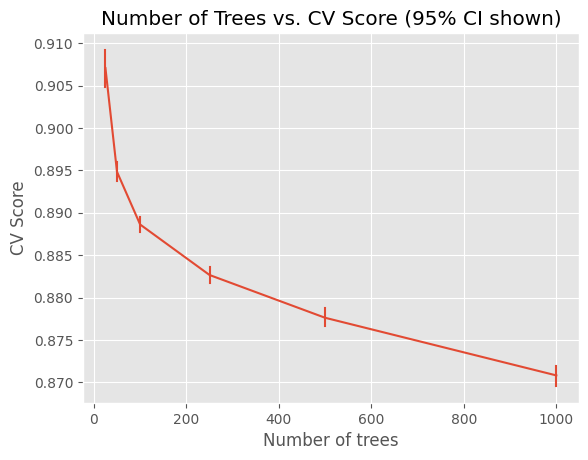

In [62]:
sns.lineplot(data=grid_cv_results_gbm, x='param_gradientboostingclassifier__n_estimators',
             y='mean_test_score', err_style='bars')
plt.ylabel('CV Score')
plt.xlabel('Number of trees')
plt.title('Number of Trees vs. CV Score (95% CI shown)')
plt.show()

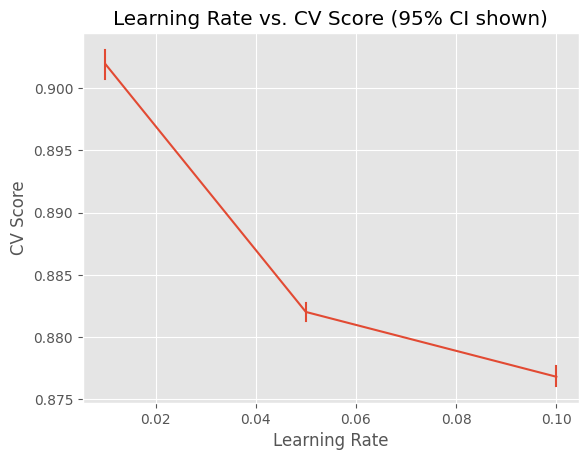

In [63]:
sns.lineplot(data=grid_cv_results_gbm, x='param_gradientboostingclassifier__learning_rate', 
             y='mean_test_score', err_style='bars')
plt.ylabel('CV Score')
plt.xlabel('Learning Rate')
plt.title('Learning Rate vs. CV Score (95% CI shown)')
plt.show()

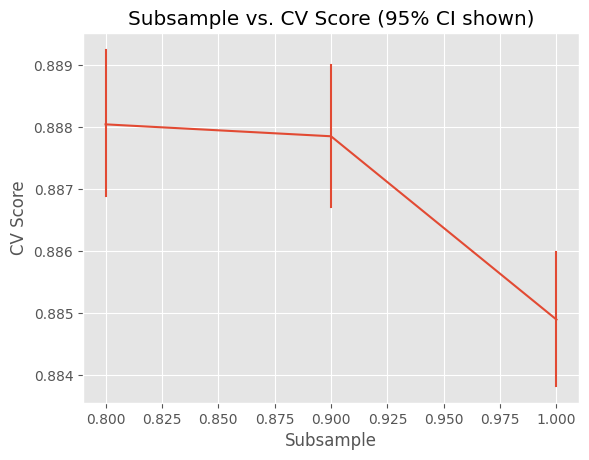

In [64]:
sns.lineplot(data=grid_cv_results_gbm, x='param_gradientboostingclassifier__subsample', 
             y='mean_test_score', err_style='bars')
plt.ylabel('CV Score')
plt.xlabel('Subsample')
plt.title('Subsample vs. CV Score (95% CI shown)')
plt.show()

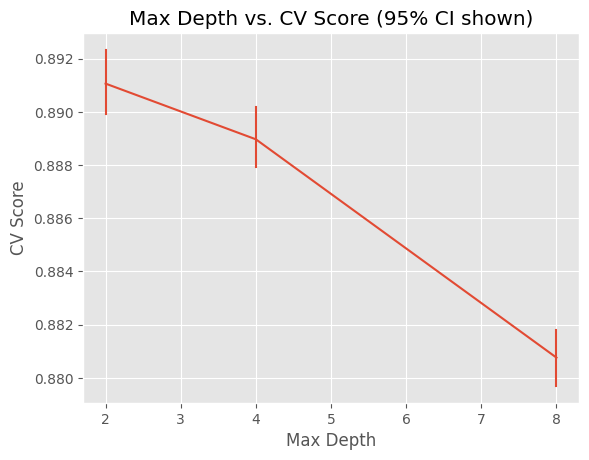

In [65]:
sns.lineplot(data=grid_cv_results_gbm, x='param_gradientboostingclassifier__max_depth', 
             y='mean_test_score', err_style='bars')
plt.ylabel('CV Score')
plt.xlabel('Max Depth')
plt.title('Max Depth vs. CV Score (95% CI shown)')
plt.show()

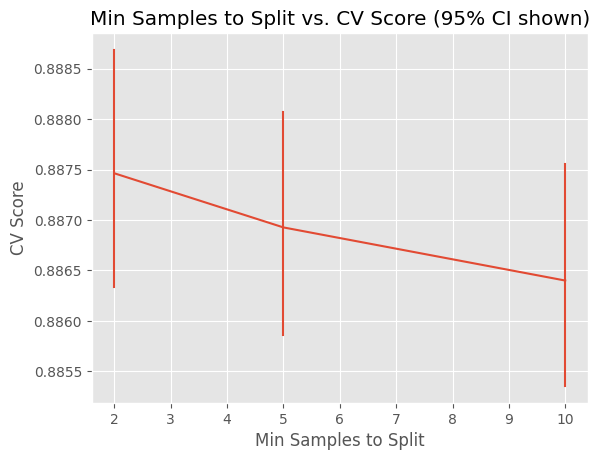

In [66]:
sns.lineplot(data=grid_cv_results_gbm, x='param_gradientboostingclassifier__min_samples_split', 
             y='mean_test_score', err_style='bars')
plt.ylabel('CV Score')
plt.xlabel('Min Samples to Split')
plt.title('Min Samples to Split vs. CV Score (95% CI shown)')
plt.show()

In [67]:
grid_cv_gbm.best_params_

{'gradientboostingclassifier__learning_rate': 0.01,
 'gradientboostingclassifier__loss': 'exponential',
 'gradientboostingclassifier__max_depth': 2,
 'gradientboostingclassifier__max_features': 'sqrt',
 'gradientboostingclassifier__min_samples_split': 2,
 'gradientboostingclassifier__n_estimators': 25,
 'gradientboostingclassifier__subsample': 0.8,
 'simpleimputer__strategy': 'mean'}

In [68]:
final_gbm = grid_cv_gbm.best_estimator_
final_gbm.fit(X_train, y_train)
y_hat_gbm = final_gbm.predict(X_test)
recall_gbm = recall_score(y_test, y_hat_gbm)

print(f'Boosted Tree Train CV Score (recall): {grid_cv_gbm.best_score_:.3f}')
print(f'Boosted Tree Test Recall: {recall_gbm:.3f}')

Boosted Tree Train CV Score (recall): 0.969
Boosted Tree Test Recall: 0.979


In [70]:
print('GBM Feature Importances:\n')
for i,j in zip(X.columns, 
               final_gbm['gradientboostingclassifier'].feature_importances_):
    print(i, ': ', j)

GBM Feature Importances:

Age :  0.011452651760666269
RestingBP :  0.0008190870141070683
Cholesterol :  0.0
FastingBS :  0.03179651898988202
MaxHR :  0.026613498169522572
Oldpeak :  0.1444427747121785
Sex_M :  0.02506495294894857
ExerciseAngina_Y :  0.16941241660902207
ChestPainType_ATA :  0.05058374225033007
ChestPainType_NAP :  0.0032952314121088397
ChestPainType_TA :  0.0
RestingECG_Normal :  0.0
RestingECG_ST :  0.0008105502976482212
ST_Slope_Flat :  0.20537690239403372
ST_Slope_Up :  0.3179256108446792
Oldpeak_is_zero :  0.012406062596872823


In [71]:
final_gbm_performance = {'model': 'gradient_boosted_tree', 
                          'params': final_gbm.get_params(), 
                          'train_score_cv_recall': grid_cv_gbm.best_score_, 
                          'test_score_recall': recall_gbm}

field_names = final_gbm_performance.keys()

with open('../data/models.csv', 'a') as file:
    writer = DictWriter(file, fieldnames=field_names)
    writer.writerow(final_gbm_performance)

## Light Gradient Boosted Trees (LGBM)

### Baseline LGBM

In [72]:
lgbm_baseline = LGBMClassifier(random_state=0)
cv_score_lgbm_baseline = cross_val_score(lgbm_baseline, X_train_imputed, y_train, 
                                         cv=5, scoring='recall').mean()
lgbm_baseline.fit(X_train_imputed, y_train)
lgbm_baseline_recall = recall_score(y_test, lgbm_baseline.predict(X_test_imputed))

print(f'LGBM Baseline CV Score: {cv_score_lgbm_baseline:.3f}')
print(f'LGBM Baseline Test Recall: {lgbm_baseline_recall:.3f}')

LGBM Baseline CV Score: 0.874
LGBM Baseline Test Recall: 0.904


In [73]:
lgbm_baseline.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 0,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [75]:
print('Baseline Feature Importances:\n')
for i,j in zip(X.columns, lgbm_baseline.feature_importances_):
    print(i, ': ', j)

Baseline Feature Importances:

Age :  416
RestingBP :  397
Cholesterol :  451
FastingBS :  72
MaxHR :  602
Oldpeak :  337
Sex_M :  80
ExerciseAngina_Y :  78
ChestPainType_ATA :  59
ChestPainType_NAP :  80
ChestPainType_TA :  34
RestingECG_Normal :  93
RestingECG_ST :  47
ST_Slope_Flat :  72
ST_Slope_Up :  53
Oldpeak_is_zero :  25


### HyperParameter Tuning

In [76]:
lgbm_pipe = make_pipeline(SimpleImputer(),
                          LGBMClassifier(random_state=0))

lgbm_params = {'simpleimputer__strategy': ['mean', 'median'],
              'lgbmclassifier__boosting_type': ['gbdt'],
              'lgbmclassifier__n_estimators': [25, 50, 75, 100, 200, 250, 500, 1000],
              'lgbmclassifier__learning_rate': [0.01, 0.05, 0.1],
              'lgbmclassifier__subsample': [0.8, 0.9, 1.0],
              'lgbmclassifier__min_child_samples': [2, 4, 16],
              'lgbmclassifier__max_depth': [2, 4, 8],
              'lgbmclassifier__colsample_bytree': [0.25, 0.5, 1.0],
              'lgbmclassifier__class_weight': [None, 'balanced']
              }

grid_cv_lgbm = GridSearchCV(lgbm_pipe, param_grid=lgbm_params, cv=5, scoring='recall', n_jobs=-1)
grid_cv_lgbm.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('lgbmclassifier',
                                        LGBMClassifier(random_state=0))]),
             n_jobs=-1,
             param_grid={'lgbmclassifier__boosting_type': ['gbdt'],
                         'lgbmclassifier__class_weight': [None, 'balanced'],
                         'lgbmclassifier__colsample_bytree': [0.25, 0.5, 1.0],
                         'lgbmclassifier__learning_rate': [0.01, 0.05, 0.1],
                         'lgbmclassifier__max_depth': [2, 4, 8],
                         'lgbmclassifier__min_child_samples': [2, 4, 16],
                         'lgbmclassifier__n_estimators': [25, 50, 75, 100, 200,
                                                          250, 500, 1000],
                         'lgbmclassifier__subsample': [0.8, 0.9, 1.0],
                         'simpleimputer__strategy': ['mean', 'median']},
             scoring='recall')

In [77]:
grid_cv_results_lgbm=pd.DataFrame(grid_cv_lgbm.cv_results_).sort_values('mean_test_score', ascending=False)
grid_cv_results_lgbm[['param_simpleimputer__strategy',
                      'param_lgbmclassifier__boosting_type', 
                      'param_lgbmclassifier__n_estimators', 
                      'param_lgbmclassifier__learning_rate', 
                      'param_lgbmclassifier__subsample', 
                      'param_lgbmclassifier__min_child_samples', 
                      'param_lgbmclassifier__max_depth', 
                      'param_lgbmclassifier__colsample_bytree', 
                      'param_lgbmclassifier__class_weight', 
                      'mean_test_score', 'std_test_score', 'rank_test_score']].head()

,param_simpleimputer__strategy,param_lgbmclassifier__boosting_type,param_lgbmclassifier__n_estimators,param_lgbmclassifier__learning_rate,param_lgbmclassifier__subsample,param_lgbmclassifier__min_child_samples,param_lgbmclassifier__max_depth,param_lgbmclassifier__colsample_bytree,param_lgbmclassifier__class_weight,mean_test_score,std_test_score,rank_test_score
389,median,gbdt,25,0.01,1.0,16,8,0.25,None,0.970967,0.019548,1
387,median,gbdt,25,0.01,0.9,16,8,0.25,None,0.970967,0.019548,1
385,median,gbdt,25,0.01,0.8,16,8,0.25,None,0.970967,0.019548,1
0,mean,gbdt,25,0.01,0.8,2,2,0.25,None,0.970967,0.018001,4
48,mean,gbdt,25,0.01,0.8,4,2,0.25,None,0.970967,0.018001,4


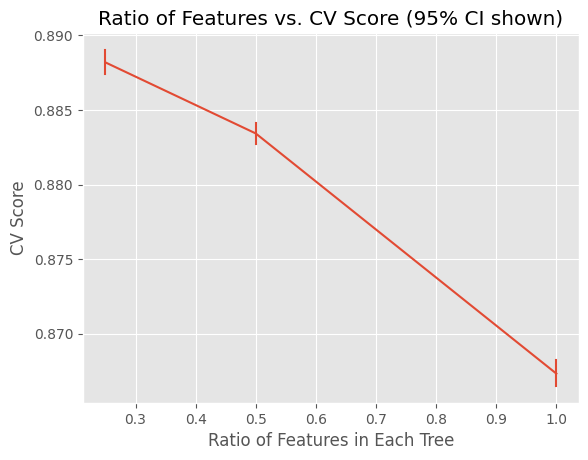

In [78]:
sns.lineplot(data=grid_cv_results_lgbm, x='param_lgbmclassifier__colsample_bytree', 
             y='mean_test_score', err_style='bars')
plt.ylabel('CV Score')
plt.xlabel('Ratio of Features in Each Tree')
plt.title('Ratio of Features vs. CV Score (95% CI shown)')
plt.show()

In [79]:
grid_cv_lgbm.best_params_

{'lgbmclassifier__boosting_type': 'gbdt',
 'lgbmclassifier__class_weight': None,
 'lgbmclassifier__colsample_bytree': 0.25,
 'lgbmclassifier__learning_rate': 0.01,
 'lgbmclassifier__max_depth': 8,
 'lgbmclassifier__min_child_samples': 16,
 'lgbmclassifier__n_estimators': 25,
 'lgbmclassifier__subsample': 0.8,
 'simpleimputer__strategy': 'median'}

In [80]:
final_lgbm = grid_cv_lgbm.best_estimator_
final_lgbm.fit(X_train, y_train)
y_hat_lgbm = final_lgbm.predict(X_test)
recall_lgbm = recall_score(y_test, y_hat_lgbm)

print(f'Light Boosted Tree Train CV Score (recall): {grid_cv_lgbm.best_score_:.3f}')
print(f'Light Boosted Tree Test Recall: {recall_lgbm:.3f}')

Light Boosted Tree Train CV Score (recall): 0.971
Light Boosted Tree Test Recall: 0.989


In [82]:
print('LGBM Feature Importances:\n')
for i,j in zip(X.columns, final_lgbm['lgbmclassifier'].feature_importances_):
    print(i, ': ', j)

LGBM Feature Importances:

Age :  38
RestingBP :  193
Cholesterol :  109
FastingBS :  11
MaxHR :  32
Oldpeak :  136
Sex_M :  7
ExerciseAngina_Y :  2
ChestPainType_ATA :  6
ChestPainType_NAP :  30
ChestPainType_TA :  1
RestingECG_Normal :  14
RestingECG_ST :  12
ST_Slope_Flat :  9
ST_Slope_Up :  8
Oldpeak_is_zero :  12


In [83]:
final_lgbm_performance = {'model': 'light_gradient_boosted_tree', 
                          'params': final_lgbm.get_params(), 
                          'train_score_cv_recall': grid_cv_lgbm.best_score_, 
                          'test_score_recall': recall_lgbm}

field_names = final_lgbm_performance.keys()

with open('../data/models.csv', 'a') as file:
    writer = DictWriter(file, fieldnames=field_names)
    writer.writerow(final_lgbm_performance)